# Problem statement
This project investigates whether public attention to renewable energy influences financial market volatility. As a quantifiable proxy for public interest, Google Trends data provides a useful tool for exploring this relationship empirically. Rather than analyzing a broad renewable energy index, the study focuses on the leading wind turbine manufacturer Vestas, allowing for a more targeted analysis in terms of company-specific and regional factors.

The central research question is:
### “Can search interest in renewable energy, as measured by Google Trends data, affect market uncertainty and, by proxy, affect the stock price volatility of the wind turbine company Vestas?” *


The initial hypothesis is that increased public interest in renewable energy is positively correlated with stock price volatility. This assumption is based on the idea that heightened search activity often coincides with both positive and negative news or developments that increase investor uncertainty and lead to greater price fluctuations. However, the direction and strength of this relationship are uncertain, motivating the need for an empirical analysis.


In [2]:
library(quantmod)
library(xts)
library(rumidas)
library(rugarch)

Warning message:
"package 'quantmod' was built under R version 4.3.3"
Loading required package: xts

Warning message:
"package 'xts' was built under R version 4.3.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.3.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: TTR

Warning message:
"package 'TTR' was built under R version 4.3.3"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"package 'rumidas' was built under R version 4.3.3"
Loading required package: maxLik

Warning message:
"package 'maxLik' was built under R version 4.3.3"
Loading required package: miscTools

Warning message:
"package 'miscTools' was built under R version 4.3.3"

Please cite the 'maxLik' package as:
Henningsen, Arne and Toomet, Ott (2011). maxLik: A package for maximum likelihood estimation in R. Computational

## Read datasets
As mentioned in the problem statement section, the data used was Google Trends data and financial data from the wind turbine company Vestas. 

### Google data
For the Google Trends data set, the group found a publicly available data set for Monthly Google Trends search volumes for keywords related to renewable energy. This is available via the International Energy Agency, and contains search volume data for 40 energy-related terms across 45 countries. The data set contains data from January 2010 to August 2022.

In [3]:
google_data <- read.csv("google_data.csv", header = TRUE, stringsAsFactors = FALSE)

### Vestas stock price data

To obtain financial data from Vestas, the group used the built-in function in R-code that retrieves historical financial data from the same period as the Google data, from Yahoo Finance. 


In [4]:

symbol <- "VWS.CO"  # Vestas Wind Systems (Copenhagen Stock Exchange)
start_date <- as.Date("2010-01-01")
end_date <- as.Date("2022-08-31")
getSymbols(symbol, src = "yahoo", from = start_date, to = end_date)
vestas_data <- Cl(get(symbol))  # Cl() extracts the closing prices
vestas_df <- data.frame(date = index(vestas_data), price = coredata(vestas_data))


[1] "VWS.CO"

## Clean and prepare the data

### Google data

The data was cleaned by taking out what were considered less relevant words and countries outside of Europe. The words left in the dataset after this cleaning are given in the list below.
* Batteries
* Electric vehicle
* Electricity
* Electrification
* Geothermal
* Heat pump
* Hydroelectricity
* Hydrogen
* Nuclear
* Offshore wind
* Solar power
* Train
* Wind power

The cleaning of the Google trends data set also included selecting the relevant columns and removing the rest, to minimize redundant data. Further, the date format was converted to a proper date format, and aggregated to get an average for Europe. 



In [5]:

# Select only the relevant columns
google_data <- google_data[, c("country", "countryISO", "techSector", "year", "value")]

# Define the sectors you're interested in
tech_sectors <- c("Batteries", "Electric vehicle", "Electricity", "Electrification", 
                  "Geothermal", "Heat pump", "Hydroelectricity", "Hydrogen", 
                  "Nuclear", "Offshore wind", "Solar power", "Train", "Wind power")

# Filter for the selected tech sectors
google_data <- google_data[google_data$techSector %in% tech_sectors, ]

european_countries <- c("France", "Italy", "Sweden", "Austria", "Turkey", 
                         "Slovak Republic", "Belgium", "United Kingdom", 
                         "Portugal", "Ireland", "Switzerland", "Finland", 
                         "Norway", "Germany", "Netherlands")
google_data_european <- google_data[google_data$country %in% european_countries, ]


colnames(google_data)[colnames(google_data) == "year"] <- "date"

# Convert the date column into a proper date format
google_data$date <- as.Date(paste0(substr(google_data$date, 1, 2), 
                                   "-", substr(google_data$date, 3, 4), 
                                   "-01"), 
                            format = "%y-%m-%d")
# Convert back to Date type
google_data$date <- as.Date(google_data$date)

colnames(google_data_european)[colnames(google_data_european) == "year"] <- "date"
# Convert the date column into a proper date format for the European data
google_data_european$date <- as.Date(paste0(substr(google_data_european$date, 1, 2), 
                                             "-", substr(google_data_european$date, 3, 4), 
                                             "-01"), 
                                      format = "%y-%m-%d")
# Convert back to Date type for the European data
google_data_european$date <- as.Date(google_data_european$date)

# Aggregate: Compute average value for each month
google_monthly_avg <- aggregate(value ~ date, data = google_data, FUN = mean)
google_data_european_monthly_avg <- aggregate(value ~ date, data = google_data_european, FUN = mean)

head(google_monthly_avg)
head(google_data_european_monthly_avg)


,date,value
,<date>,<dbl>
1,2010-01-01,4.682794
2,2010-02-01,4.591593
3,2010-03-01,4.745969
4,2010-04-01,4.914769
5,2010-05-01,4.848954
6,2010-06-01,4.842765


,date,value
,<date>,<dbl>
1,2010-01-01,4.646908
2,2010-02-01,4.462741
3,2010-03-01,4.785163
4,2010-04-01,5.008614
5,2010-05-01,4.479021
6,2010-06-01,4.890323


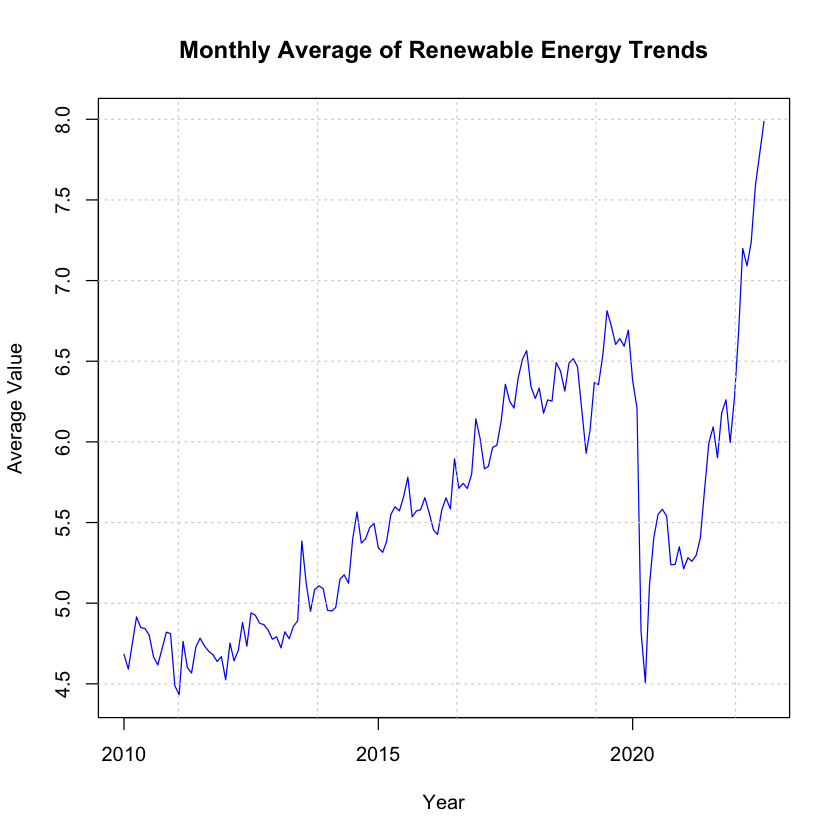

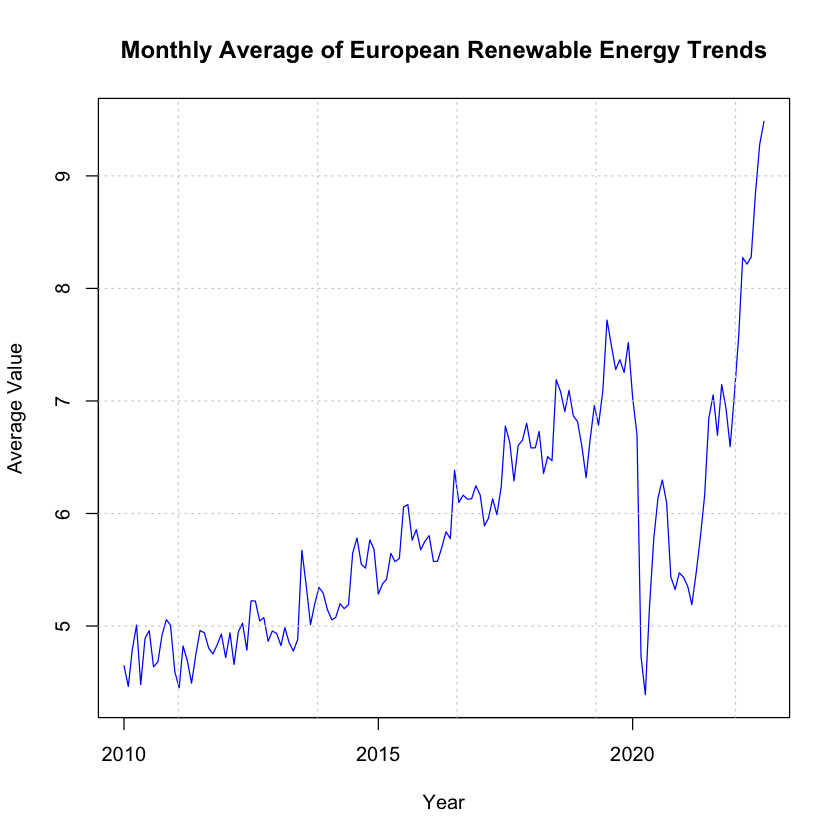

In [6]:
par(bg = "white")
plot(google_monthly_avg$date, google_monthly_avg$value, type = "l", col = "blue",
     xlab = "Year", ylab = "Average Value", main = "Monthly Average of Renewable Energy Trends")
# Add grid for better readability
grid()

par(bg = "white")
plot(google_data_european_monthly_avg$date, google_data_european_monthly_avg$value, type = "l", col = "blue",
     xlab = "Year", ylab = "Average Value", main = "Monthly Average of European Renewable Energy Trends")
# Add grid for better readability
grid()



### Vestas stock price data
First, the code plots the data for visualization. Next, the code calculates the daily log returns by taking the difference in the natural logarithm of consecutive stock prices. These returns are stored in a new data frame alongside their corresponding dates and plotted to visualize fluctuations in daily returns. This serves as a measure of stock price volatility.


In [7]:

# Rename the column for easier access
colnames(vestas_df)[2] <- "price"
vestas_df$date <- as.Date(vestas_df$date)

#vestas_df


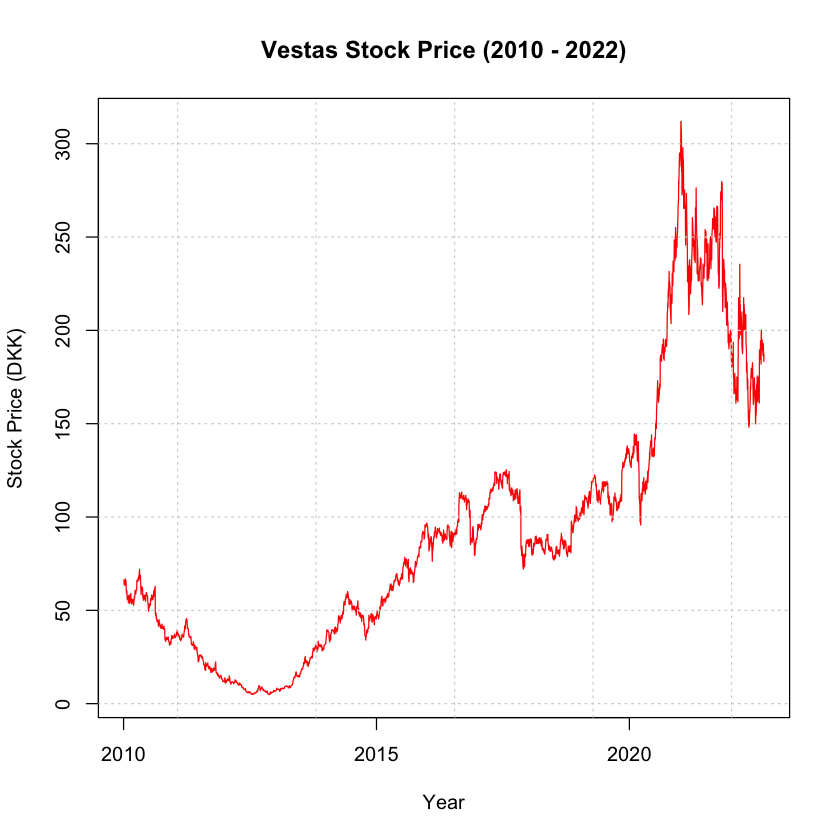

In [8]:

# Plot Vestas stock price over time
par(bg = "white")
plot(vestas_df$date, vestas_df$price, type = "l", col = "red",
     xlab = "Year", ylab = "Stock Price (DKK)", 
     main = "Vestas Stock Price (2010 - 2022)")
# Add grid for better readability
grid()


,date,log_return
,<date>,<dbl>
1,2010-01-05,-0.030894096
2,2010-01-06,-0.012503999
3,2010-01-07,0.008145356
4,2010-01-08,-0.004691162
5,2010-01-11,0.030866706
6,2010-01-12,-0.037155999


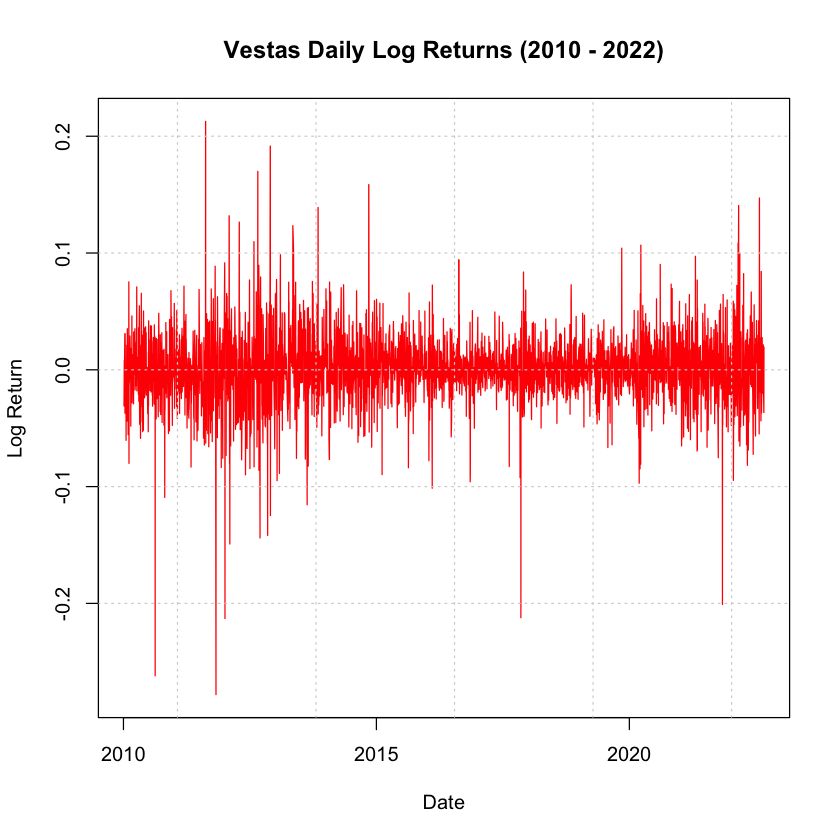

In [9]:

# Calculate the log returns (difference of log prices)
vestas_daily_returns <- diff(log(vestas_df$price))

# Create a new data frame with the corresponding dates and returns
vestas_returns_df <- data.frame(date = vestas_df$date[-1], log_return = vestas_daily_returns)

# View the data frame
head(vestas_returns_df)

# Plot the log returns over time
par(bg = "white")
plot(vestas_returns_df$date, vestas_returns_df$log_return, type = "l", col = "red", 
     xlab = "Date", ylab = "Log Return", 
     main = "Vestas Daily Log Returns (2010 - 2022)")

# Add grid for better readability
grid()




## Transfrom data to xts
Both trend data and financial data is converted into xts time-series objects, allowing for easier alignment and analysis of the two datasets in time-series models.

### European Google data


In [10]:
google_monthly_avg_xts <- xts(google_data_european_monthly_avg$value, order.by = google_data_european_monthly_avg$date)
colnames(google_monthly_avg_xts) <- "value"
head(google_monthly_avg_xts)

              value
2010-01-01 4.646908
2010-02-01 4.462741
2010-03-01 4.785163
2010-04-01 5.008614
2010-05-01 4.479021
2010-06-01 4.890323

### Vestas log return data

In [11]:
vestas_daily_returns_xts <- xts(vestas_returns_df$log_return, order.by = vestas_returns_df$date)
colnames(vestas_daily_returns_xts) <- "return"
head(vestas_daily_returns_xts)

                 return
2010-01-05 -0.030894096
2010-01-06 -0.012503999
2010-01-07  0.008145356
2010-01-08 -0.004691162
2010-01-11  0.030866706
2010-01-12 -0.037155999

## Garch-Midas
GARCH-MIDAS is a GARCH model that enables use of data with different frequencies, allowing the model to compare low-frequency macro data with high-frequency financial data. The model can therefore examine the effect of macroeconomic variables on a stock volatility. This makes it an ideal model for the project, as the Google Trends data is only available on a monthly basis.


### Alignment of dates 
This part of the code aligns daily return data with monthly average data by trimming the daily data to match a specific time window. It first sets a starting point K months into the monthly data and updates the daily data to start from that date if needed. Then, it ensures the daily data doesn't extend beyond the last date of the monthly data. This prepares both datasets for consistent time alignment when fitting the model.


In [12]:
K_value <- 3

# Identify the starting date of the monthly data
start_monthly <- index(google_monthly_avg_xts)[1]

# Add K months to the starting date
new_start_date <- as.Date(seq(start_monthly, by = "month", length.out = K_value + 1)[K_value + 1])

# Adjust the daily data to start from the new date only if needed
if (index(vestas_daily_returns_xts)[1] < new_start_date) {
  vestas_daily_returns_xts <- vestas_daily_returns_xts[new_start_date <= index(vestas_daily_returns_xts)]
}

# Ensure the end date of daily data doesn't exceed the end date of monthly data
end_monthly <- index(google_monthly_avg_xts)[length(google_monthly_avg_xts)]
if (index(vestas_daily_returns_xts)[length(vestas_daily_returns_xts)] > end_monthly) {
  vestas_daily_returns_xts <- vestas_daily_returns_xts[index(vestas_daily_returns_xts) <= end_monthly]
}

# head(vestas_daily_returns_xts)
# tail(vestas_daily_returns_xts)

# head(google_monthly_avg_xts)
# tail(google_monthly_avg_xts)


## Fitting the model

In [13]:
dist_GM <- "std"
chosen_weighting_function <- "Beta"

mv_m <- mv_into_mat(x = vestas_daily_returns_xts$return , mv = google_monthly_avg_xts, K = K_value, type = "monthly")

GM <- ugmfit(
    model = "GM",
    skew = "NO",
    distribution = dist_GM,
    daily_ret = vestas_daily_returns_xts$return ,
    mv_m = mv_m,
    K = K_value, 
    lag_fun = chosen_weighting_function
)

GM
summary.rumidas(GM)
names(GM)
print(GM$loglik)
print(GM$inf_criteria)




Model: GM 

Coefficients: 
alpha     beta      m         theta     w2        shape     
0.0281    0.9709    -7.2912   0.1886    19.2443   3.8974    



Coefficients:
      Estimate Std. Error  t value Pr(>|t|) Sig.
alpha   0.0281     0.0133   2.1116   0.0347   **
beta    0.9709     0.0139  70.0635   0.0000  ***
m      -7.2912     0.1929 -37.8020   0.0000  ***
theta   0.1886     0.0812   2.3214   0.0203   **
w2     19.2443     0.0504 381.8062   0.0000  ***
shape   3.8974     0.0752  51.8147   0.0000  ***
--- 
Signif. codes: 0.01 '***', 0.05 '**', 0.1 '*' 

Obs.: 3077. Sample Period: 2010-04-06/2022-08-01 
MSE(%): 0.000947;  QLIKE: -6.130612 



[1] "model"        "rob_coef_mat" "obs"          "period"       "loglik"      
[6] "inf_criteria" "loss_in_s"    "est_vol_in_s" "est_lr_in_s"

[1] 8651.503
      AIC       BIC 
-17291.01 -17254.82 


In [14]:
K_values <- c(3, 6, 9, 12)
distributions <- c("norm", "std") #Removed "ged" because of error
lag_functions <- c("Beta", "Almon") #removed "expalmon" Because error

results <- list()

for (K in K_values) {
  for (dist in distributions) {
    for (lag_fun in lag_functions) {
      model_key <- paste0("K", K, "_", dist, "_", lag_fun)
      cat(sprintf("Fitting GM: %s\n", model_key))
      
      tryCatch({
        # Adjust starting point for K
        start_monthly <- index(google_monthly_avg_xts)[1]
        new_start_date <- as.Date(seq(start_monthly, by = "month", length.out = K + 1)[K + 1])
        
        adj_returns <- vestas_daily_returns_xts
        if (index(adj_returns)[1] < new_start_date) {
          adj_returns <- adj_returns[new_start_date <= index(adj_returns)]
        }
        
        # Align with end date
        end_monthly <- index(google_monthly_avg_xts)[length(google_monthly_avg_xts)]
        if (index(adj_returns)[length(adj_returns)] > end_monthly) {
          adj_returns <- adj_returns[index(adj_returns) <= end_monthly]
        }
        
        mv_m <- mv_into_mat(
          x = adj_returns$return,
          mv = google_monthly_avg_xts,
          K = K,
          type = "monthly"
        )
        
        model <- ugmfit(
          model = "GM",
          skew = "NO",
          distribution = dist,
          daily_ret = adj_returns$return,
          mv_m = mv_m,
          K = K,
          lag_fun = lag_fun
        )
        
        results[[model_key]] <- list(
          model = model,
          AIC = model$inf_criteria["AIC"],
          BIC = model$inf_criteria["BIC"]
        )
        
        cat(sprintf("AIC: %.2f | BIC: %.2f\n\n", model$inf_criteria["AIC"], model$inf_criteria["BIC"]))
        
      }, error = function(e) {
        cat(sprintf("Error in model %s: %s\n", model_key, e$message))
      })
    }
  }
}

Fitting GM: K3_norm_Beta
AIC: -13218.99 | BIC: -13188.83

Fitting GM: K3_norm_Almon
AIC: -13218.99 | BIC: -13188.83

Fitting GM: K3_std_Beta
AIC: -17291.01 | BIC: -17254.82

Fitting GM: K3_std_Almon
AIC: -17291.01 | BIC: -17254.82

Fitting GM: K6_norm_Beta
AIC: -12990.33 | BIC: -12960.27

Fitting GM: K6_norm_Almon
AIC: -12990.35 | BIC: -12960.28

Fitting GM: K6_std_Beta
AIC: -16985.84 | BIC: -16949.77

Fitting GM: K6_std_Almon
AIC: -16985.84 | BIC: -16949.77

Fitting GM: K9_norm_Beta
AIC: -12785.25 | BIC: -12755.30

Fitting GM: K9_norm_Almon
AIC: -12785.26 | BIC: -12755.31

Fitting GM: K9_std_Beta
AIC: -16631.65 | BIC: -16595.70

Fitting GM: K9_std_Almon
AIC: -16631.65 | BIC: -16595.70

Fitting GM: K12_norm_Beta
AIC: -12517.12 | BIC: -12487.28

Fitting GM: K12_norm_Almon
AIC: -12517.13 | BIC: -12487.29

Fitting GM: K12_std_Beta
AIC: -16270.02 | BIC: -16234.21

Fitting GM: K12_std_Almon
AIC: -16270.02 | BIC: -16234.21



In [16]:
#find the best model
best_model <- NULL
best_aic <- Inf
best_bic <- Inf
best_model_key <- NULL
for (key in names(results)) {
  model_info <- results[[key]]
  if (model_info$AIC < best_aic) {
    best_aic <- model_info$AIC
    best_model <- model_info$model
    best_model_key <- key
  }
  if (model_info$BIC < best_bic) {
    best_bic <- model_info$BIC
  }
}
cat(sprintf("Best Model: %s\n", best_model_key))
cat(sprintf("Best AIC: %.2f\n", best_aic))
cat(sprintf("Best BIC: %.2f\n", best_bic))
# Print the best model summary
cat(sprintf("Best Model Summary:\n"))
#print summry.rumidas(best_model))
summary.rumidas(best_model)   

Best Model: K3_std_Almon
Best AIC: -17291.01
Best BIC: -17254.82
Best Model Summary:

Coefficients:
      Estimate Std. Error  t value Pr(>|t|) Sig.
alpha   0.0281     0.0147   1.9158   0.0554    *
beta    0.9709     0.0151  64.3089   0.0000  ***
m      -7.2912     0.3168 -23.0184   0.0000  ***
theta   0.1886     0.0624   3.0229   0.0025  ***
w2     -3.3846     0.1544 -21.9200   0.0000  ***
shape   3.8975     0.0999  38.9997   0.0000  ***
--- 
Signif. codes: 0.01 '***', 0.05 '**', 0.1 '*' 

Obs.: 3077. Sample Period: 2010-04-06/2022-08-01 
MSE(%): 0.000947;  QLIKE: -6.130614 



## Conclusion
The results show slight positive correlation that is statistically significant. This indicates that search trends for energy terms can explain some of the stock price volatility for Vestas. A slight positive correlation suggests that increased public attention, as captured by Google Trends data, may signal slightly heightened uncertainty or market reactions. This is possibly triggered by news, policy changes, or events related to renewable energy. When attention spikes, it may reflect a flow of new information or investor sentiment shifts, both of which can lead to more trading activity and price fluctuations. This aligns with the idea and initial hypothesis that greater public awareness, especially during periods of debate or disruption in the renewable energy sector, can lead to some increase in volatility. However, most of the volatility is driven by other factors.

In extension of the discussion above, there is reason to reflect on what other factors Vestas’ stock price is affected by in addition to retail investors and public opinion. We cannot draw any causality conclusions, as a variety of other factors may have affected the in-sample results. Furthermore, considering the fact that 85% (https://www.vestas.com/en/investor/share-and-capital-structure/share-information#accordion-7647c6cd9b-item-2a7d04ede7) of Vestas is held by institutional investors, one could also assume that the traded volume driving price discovery is majorly institutional. Hence, even if our findings were generalizable and robust out of sample, it would still be hard to draw causal conclusions, as the price and google search data are driven by largely independent factors. 

## Use of LLM
